In [243]:
#importamos las librerias y el archivo con el que vamos a trabajar
import kagglehub
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns

# Download latest version
url = ('https://raw.githubusercontent.com/malozoyab/fertility/refs/heads/main/fertility.csv')

df = pd.read_csv(url)

In [244]:
#muestra de los datos
df.head()

,Season,Age,Childish diseases,Accident or serious trauma,Surgical intervention,High fevers in the last year,Frequency of alcohol consumption,Smoking habit,Number of hours spent sitting per day,Diagnosis
0,spring,30,no,yes,yes,more than 3 months ago,once a week,occasional,16,Normal
1,spring,35,yes,no,yes,more than 3 months ago,once a week,daily,6,Altered
2,spring,27,yes,no,no,more than 3 months ago,hardly ever or never,never,9,Normal
3,spring,32,no,yes,yes,more than 3 months ago,hardly ever or never,never,7,Normal
4,spring,30,yes,yes,no,more than 3 months ago,once a week,never,9,Altered


In [245]:
# Información general del dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110 entries, 0 to 109
Data columns (total 10 columns):
 #   Column                                 Non-Null Count  Dtype 
---  ------                                 --------------  ----- 
 0   Season                                 110 non-null    object
 1   Age                                    110 non-null    int64 
 2   Childish diseases                      110 non-null    object
 3   Accident or serious trauma             110 non-null    object
 4   Surgical intervention                  110 non-null    object
 5   High fevers in the last year           110 non-null    object
 6   Frequency of alcohol consumption       110 non-null    object
 7   Smoking habit                          110 non-null    object
 8   Number of hours spent sitting per day  110 non-null    int64 
 9   Diagnosis                              110 non-null    object
dtypes: int64(2), object(8)
memory usage: 8.7+ KB


Tenemos 110 entradas y 10 variables, la variable a predecir sera la de Diagnosis

In [246]:
#Verificar valores nulos
df.isnull().sum()

Season                                   0
Age                                      0
Childish diseases                        0
Accident or serious trauma               0
Surgical intervention                    0
High fevers in the last year             0
Frequency of alcohol consumption         0
Smoking habit                            0
Number of hours spent sitting per day    0
Diagnosis                                0
dtype: int64

No encontramos ningun valor nulo en las variables

In [247]:
# Descripción estadística de las variables numéricas
df.describe()

,Age,Number of hours spent sitting per day
count,110.000000,110.000000
mean,30.163636,10.645455
std,2.240279,32.059745
min,27.000000,1.000000
25%,28.000000,5.000000
50%,30.000000,7.000000
75%,32.000000,9.000000
max,36.000000,342.000000


El maximo numero de horas sentado no puede ser correcto, ya que no puedes estar sentado mas de 24 horas en un día.

In [248]:
df[df['Number of hours spent sitting per day'] >= 24]

,Season,Age,Childish diseases,Accident or serious trauma,Surgical intervention,High fevers in the last year,Frequency of alcohol consumption,Smoking habit,Number of hours spent sitting per day,Diagnosis
50,spring,30,yes,no,yes,more than 3 months ago,once a week,never,342,Normal


Tenemos una entrada con mas de 24 horas sentado, que trataremos mas adelante.

In [249]:
df['Number of hours spent sitting per day'].value_counts()

Number of hours spent sitting per day
5      18
9      17
7      13
8      12
6      12
3      10
11     10
16      4
14      3
10      3
1       2
2       1
342     1
18      1
4       1
13      1
12      1
Name: count, dtype: int64

Mostramos los distintos valores del numero de horas sentado al dia y la cantidad de cada uno.
Los valores van desde 1 a 18 horas.

In [250]:
df.nunique()

Season                                    4
Age                                      10
Childish diseases                         2
Accident or serious trauma                2
Surgical intervention                     2
High fevers in the last year              4
Frequency of alcohol consumption          5
Smoking habit                             3
Number of hours spent sitting per day    17
Diagnosis                                 2
dtype: int64

In [251]:
duplicated = df[df.duplicated()]
print(duplicated)

   Season  Age Childish diseases Accident or serious trauma  \
20   fall   30                no                         no   

   Surgical intervention High fevers in the last year  \
20                   yes       more than 3 months ago   

   Frequency of alcohol consumption Smoking habit  \
20                      once a week         never   

    Number of hours spent sitting per day Diagnosis  
20                                      5    Normal  


Encontramos un valor duplicado, puede ser un valor correcto ya que pueden coincidir varias personas con los mismos habitos, aunque tambien en la recogida de muestras han podido duplicar la entrada, por lo tanto, viendo que tenemos mas datos de diagnosis normal la vamos a eliminar.

In [252]:
df = df.drop_duplicates()

In [253]:
for col in df.select_dtypes(include=['object', 'category']).columns:
    print(df[col].value_counts(), "\n")

Season
spring    38
fall      32
winter    29
summer    10
Name: count, dtype: int64 

Childish diseases
yes    92
no     17
Name: count, dtype: int64 

Accident or serious trauma
no     63
yes    46
Name: count, dtype: int64 

Surgical intervention
no     56
yes    53
Name: count, dtype: int64 

High fevers in the last year
more than 3 months ago    65
no                        32
less than 3 months ago    10
yes                        2
Name: count, dtype: int64 

Frequency of alcohol consumption
hardly ever or never    39
once a week             38
several times a week    24
every day                7
several times a day      1
Name: count, dtype: int64 

Smoking habit
never         55
occasional    31
daily         23
Name: count, dtype: int64 

Diagnosis
Normal     87
Altered    22
Name: count, dtype: int64 



Mostramos los valores y cantidad de cada uno en las variables, para hacernos una idea de los datos que tenemos.

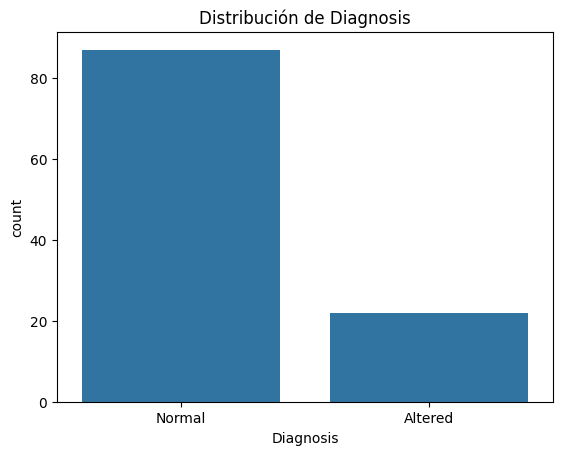

In [227]:
# Distribución de la variable objetivo (Survived)
sns.countplot(x='Diagnosis', data=df)
plt.title('Distribución de Diagnosis')
plt.show()

Como se puede ver, tenemos un desbalanceo de clases, 87 diagnosis normal y 22 diagnosis altered

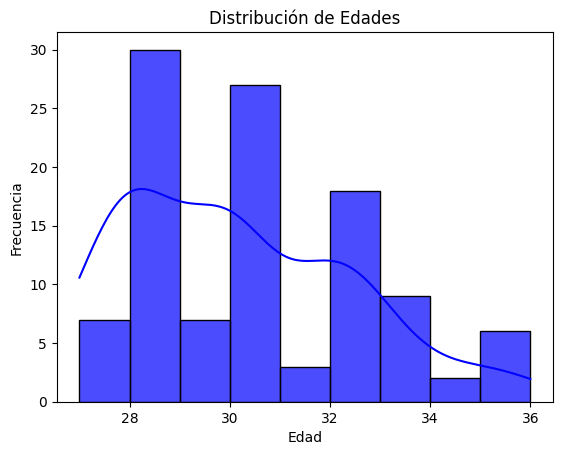

In [228]:
# Distribución de edades
sns.histplot(df['Age'], bins=9, kde=True, color='blue', edgecolor='black', alpha=0.7)
plt.title('Distribución de Edades')
plt.xlabel('Edad')
plt.ylabel('Frecuencia')
plt.show()

Representamos la distribución de las edades.

Se observan varios picos en la distribución de las edades, lo que indica que hay grupos de edades con mayor frecuencia en comparación con otros.
Parece haber una ligera asimetría hacia la derecha (cola más larga a la derecha), lo que sugiere que hay más valores concentrados en las edades más bajas.

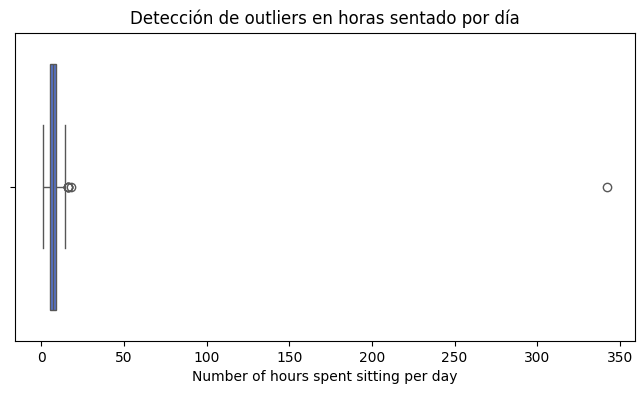

     Season  Age Childish diseases Accident or serious trauma  \
0    spring   30                no                        yes   
50   spring   30               yes                         no   
60     fall   28                no                         no   
66   spring   27               yes                        yes   
70   spring   27               yes                        yes   
104  spring   33                no                         no   

    Surgical intervention High fevers in the last year  \
0                     yes       more than 3 months ago   
50                    yes       more than 3 months ago   
60                     no                           no   
66                     no       less than 3 months ago   
70                     no       less than 3 months ago   
104                    no       more than 3 months ago   

    Frequency of alcohol consumption Smoking habit  \
0                        once a week    occasional   
50                       once

In [229]:
# Visualización de outliers en "Number of hours spent sitting per day"
plt.figure(figsize=(8, 4))
sns.boxplot(x=df["Number of hours spent sitting per day"], color="royalblue")
plt.title("Detección de outliers en horas sentado por día")
plt.show()

# Identificar valores atípicos usando el rango intercuartílico (IQR)
Q1 = df["Number of hours spent sitting per day"].quantile(0.25)
Q3 = df["Number of hours spent sitting per day"].quantile(0.75)
IQR = Q3 - Q1

# Definir límites para valores normales
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Calcular la media de los valores normales y redondear al entero más cercano
mean_value = round(df[(df["Number of hours spent sitting per day"] >= lower_bound) & 
                      (df["Number of hours spent sitting per day"] <= upper_bound)]["Number of hours spent sitting per day"].mean())

# Filtrar valores fuera de los límites
outliers = df[(df["Number of hours spent sitting per day"] < lower_bound) | 
              (df["Number of hours spent sitting per day"] > upper_bound)]

print(outliers)

print('total outliers', outliers.shape[0])

Podemos ver de nuevo el outlier,ademas detectamos que los valores de 16 o por encima los detecta como tal, en este caso los vamos a dejar ya que si podemos pasar ese nº de horas sentados.

In [230]:
# Definir el límite superior del IQR
upper_bound = Q3 + 1.5 * IQR

# Encontrar el valor más alto dentro del IQR (límite superior)
max_valid_value = df.loc[df["Number of hours spent sitting per day"] <= upper_bound, "Number of hours spent sitting per day"].max()

# Reemplazar solo los valores mayores a 24 con el máximo valor válido dentro del IQR
df.loc[df["Number of hours spent sitting per day"] > 24, "Number of hours spent sitting per day"] = max_valid_value

# Comprobar si aún hay valores atípicos mayores a 24
outliers = df[df["Number of hours spent sitting per day"] > 24]
print(outliers)
print('Total outliers:', outliers.shape[0])


Empty DataFrame
Columns: [Season, Age, Childish diseases, Accident or serious trauma, Surgical intervention, High fevers in the last year, Frequency of alcohol consumption, Smoking habit, Number of hours spent sitting per day, Diagnosis]
Index: []
Total outliers: 0


Reemplazamos los valores por encima de 24 con el mayor valor dentro de los valores que no son outliers para no sesgar demasiado el análisis

C:\Users\malozoya\AppData\Local\Temp\ipykernel_7764\1152461591.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Diagnosis", y="Age", data=df, palette="coolwarm", ax=axes[0])
C:\Users\malozoya\AppData\Local\Temp\ipykernel_7764\1152461591.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Diagnosis", y="Number of hours spent sitting per day", data=df, palette="coolwarm", ax=axes[1])


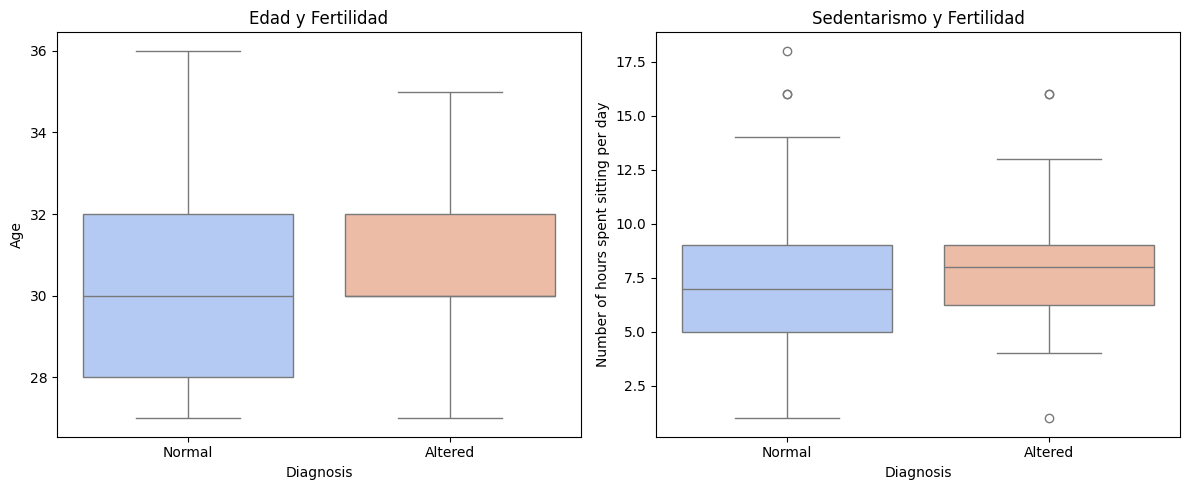

In [231]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.boxplot(x="Diagnosis", y="Age", data=df, palette="coolwarm", ax=axes[0])
axes[0].set_title("Edad y Fertilidad")

sns.boxplot(x="Diagnosis", y="Number of hours spent sitting per day", data=df, palette="coolwarm", ax=axes[1])
axes[1].set_title("Sedentarismo y Fertilidad")

plt.tight_layout()
plt.show()


Estos boxplots comparan la distribución de dos variables (Edad y Horas sentado por día) entre hombres con fertilidad Normal vs. Altered.

Edad vs. Fertilidad

La mediana de edad en el grupo Altered es mayor que en el grupo Normal.
Esto sugiere que, en la muestra, los hombres con diagnóstico de fertilidad alterada tienden a ser mayores que aquellos con diagnóstico normal.
No significa que la edad sea la causa directa, pero sí que existe una relación en el dataset.

Sedentarismo vs. Fertilidad

El boxplot muestra que el grupo Altered tiene una mediana de horas sentado al día más alta que el grupo Normal.
Esto podría señalar que un estilo de vida más sedentario podría estar asociado con una fertilidad alterada.

La visualización sugiere que mayor edad y más horas sentado podrían relacionarse con un diagnóstico de fertilidad alterada.
Importante: estos boxplots solo muestran correlaciones en la muestra analizada. Para confirmar causalidad, haría falta un estudio más profundo.

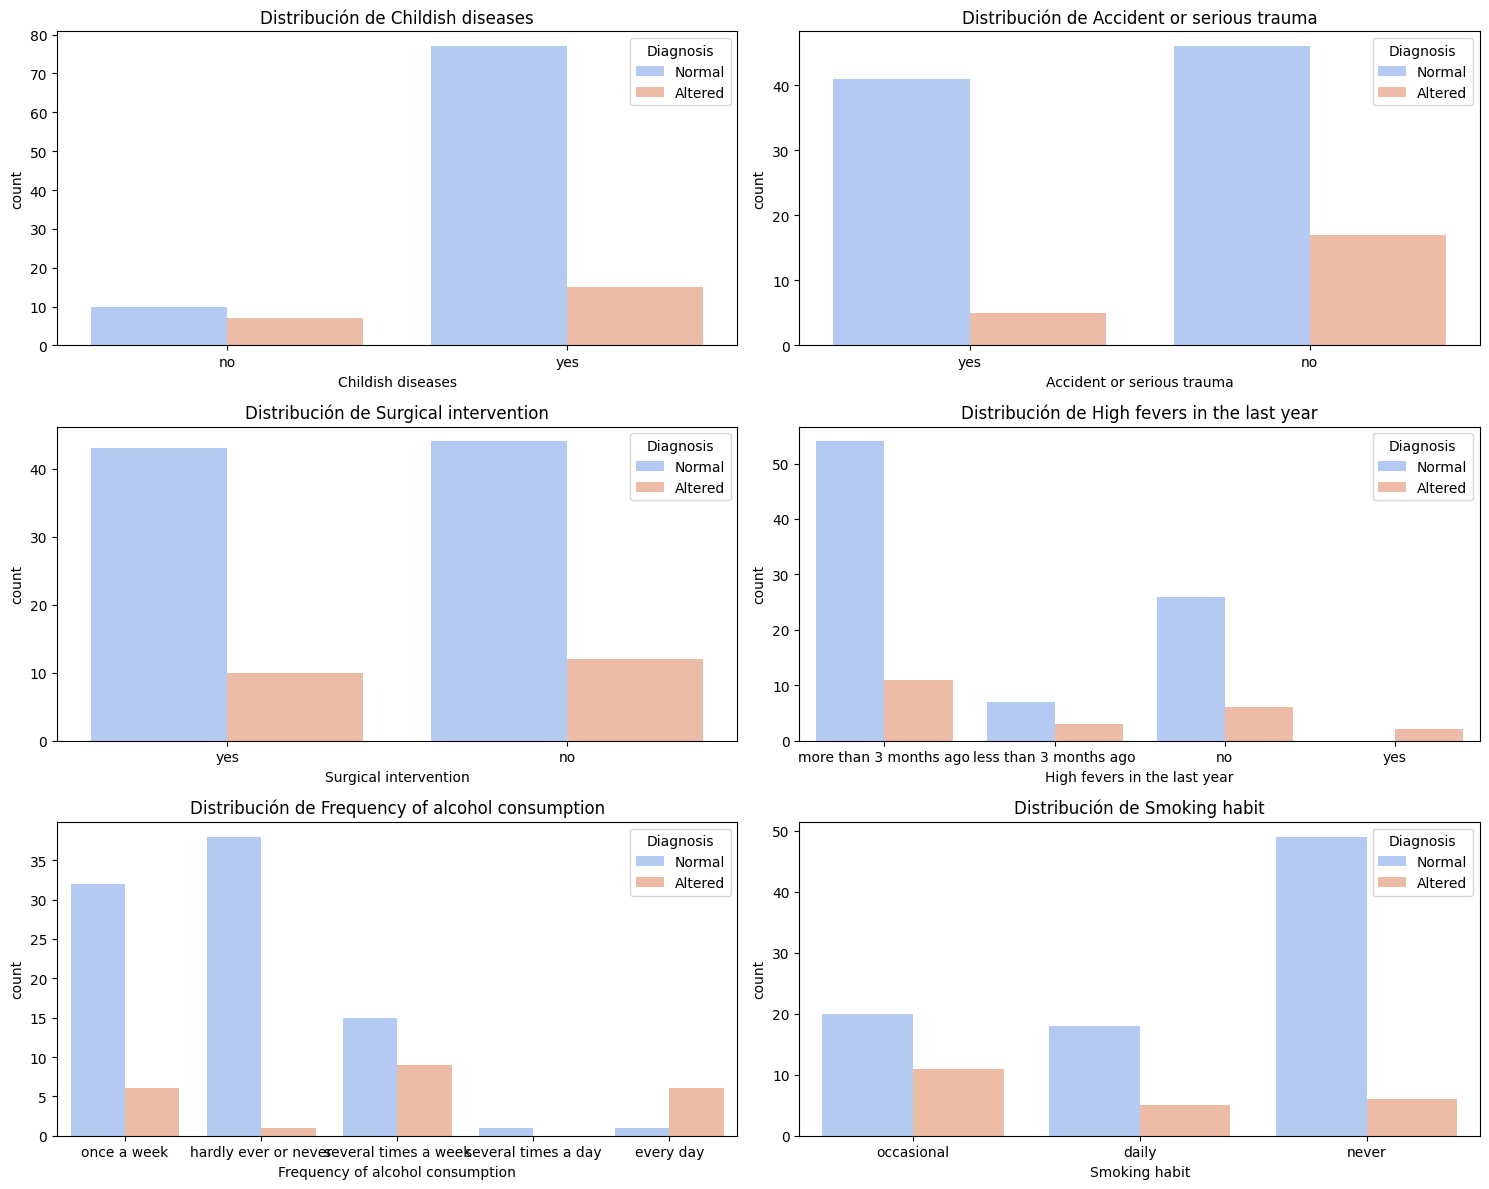

In [213]:
categorical_cols = [
    "Childish diseases", "Accident or serious trauma", "Surgical intervention",
    "High fevers in the last year", "Frequency of alcohol consumption", "Smoking habit"
]

num_cols = 2
num_rows = (len(categorical_cols) + 1) // 2  # Ensures there are 2 charts per row

fig, axes = plt.subplots(nrows=(len(categorical_cols) + 1) // 2, ncols=2, figsize=(15, 12))

for i, col in enumerate(categorical_cols):
    row = i // 2
    col_pos = i % 2
    sns.countplot(data=df, x=col, hue="Diagnosis", ax=axes[i // 2, i % 2], palette="coolwarm")
    axes[i // 2, i % 2].set_title(f"Distribución de {col}")

plt.tight_layout()
plt.show()


Distribución de Childish diseases (Enfermedades infantiles)
Se observa que la mayoría de los participantes han tenido enfermedades infantiles en su infancia.
En ambos grupos, la cantidad de personas que tuvieron enfermedades infantiles es mucho mayor que la de quienes no las tuvieron.
En proporción, parece que el porcentaje de personas con diagnóstico Altered es similar tanto en aquellos que tuvieron enfermedades infantiles como en los que no.
Esto sugiere que las enfermedades infantiles pueden no estar fuertemente relacionadas con la fertilidad alterada.

Accident or serious trauma (Accidentes o traumas graves)
Se observa que hay más individuos con diagnóstico “Normal” en la categoría “no”, pero la proporción de aquellos con diagnóstico “Altered” es más alta en comparación con los que sí sufrieron un accidente.
Esto podría sugerir que no haber tenido un accidente está más asociado con el diagnóstico “Altered” que con el “Normal”, pero esto requeriría mas pruebas.

Surgical intervention (Intervención quirúrgica)
Hay aproximadamente la misma cantidad de personas en las categorías “yes” y “no” en el grupo Normal.
Sin embargo, en el grupo Altered, parece haber un ligero aumento en aquellos que han tenido una intervención quirúrgica.
Esto sugiere que podría haber una relación leve entre haber pasado por una cirugía y un diagnóstico alterado de fertilidad, pero se necesitaría más análisis de las intervenciones realizadas.

High fevers in the last year (Fiebres altas en el último año)
La mayoría de los participantes reportaron haber tenido fiebre hace más de 3 meses.
Un menor número de personas reportó fiebre hace menos de 3 meses o no haber tenido fiebre en el último año.
En términos de diagnóstico, parece que hay una proporción mayor de individuos con diagnóstico Altered entre aquellos que no han tenido fiebre en comparación con los que sí la han tenido hace más de 3 meses. Esto podría indicar que no haber tenido fiebre en el último año está asociado con una menor fertilidad.

In [214]:
df_encoded = df.copy()  
df_encoded["Diagnosis"] = df_encoded["Diagnosis"].apply(lambda x: 1 if x == "Altered" else 0)
df_encoded = pd.get_dummies(df_encoded)  


C:\Users\malozoya\AppData\Local\Temp\ipykernel_7764\131768292.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=X.columns, y=normalized_importances, palette=colors)


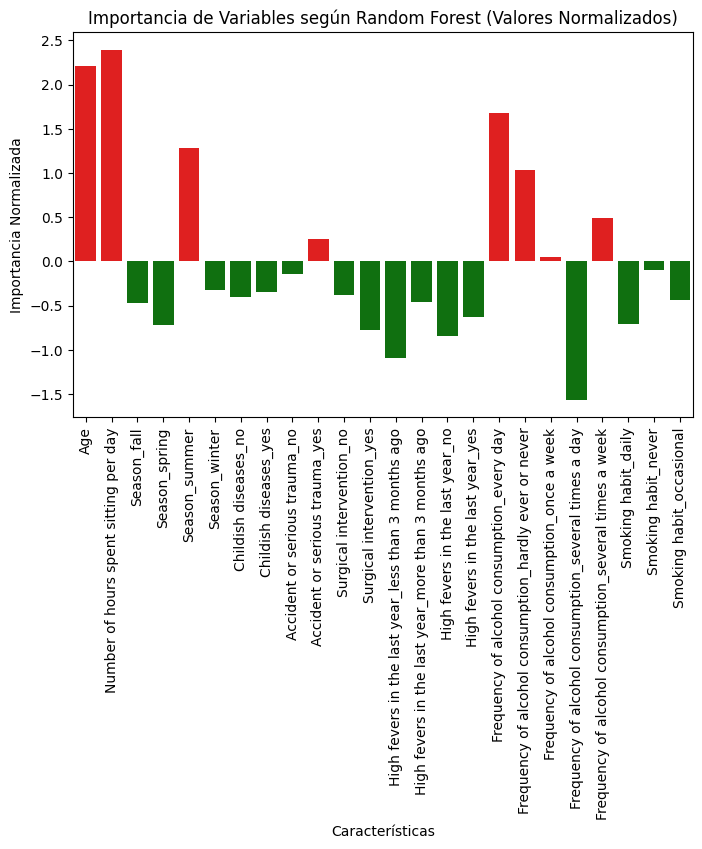

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Dividir datos en X e y
X = df_encoded.drop(columns=["Diagnosis"])
y = df_encoded["Diagnosis"]

# Separar datos en train y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Entrenar el modelo
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X, y)

# Obtener importancia de características
importances = rf.feature_importances_

# Normalizar entre -1 y 1 para resaltar dirección de impacto
normalized_importances = (importances - np.mean(importances)) / np.std(importances)

# Definir colores: rojo para valores positivos (mayor relación con "Altered"), verde para negativos ("Normal")
colors = ["red" if val > 0 else "green" for val in normalized_importances]

# Graficar
plt.figure(figsize=(8, 5))
sns.barplot(x=X.columns, y=normalized_importances, palette=colors)
plt.xticks(rotation=90)
plt.title("Importancia de Variables según Random Forest")
plt.ylabel("Importancia Normalizada")
plt.xlabel("Características")
plt.show()


In [170]:
# Dividir datos en X e y
X = df_encoded.drop(columns=["Diagnosis"])
y = df_encoded["Diagnosis"]

# Separar datos en train y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train = X_train.astype("float32")
X_test = X_test.astype("float32")

In [171]:
model = keras.Sequential([
    keras.layers.Dense(23, activation="relu", input_shape=(X_train.shape[1],)),
    keras.layers.Dense(7, activation="relu"),
    keras.layers.Dense(1, activation="sigmoid")
])

model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=50, batch_size=8, validation_data=(X_test, y_test))


Epoch 1/50


C:\Users\malozoya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.1590 - loss: 1.9258 - val_accuracy: 0.2727 - val_loss: 0.8623
Epoch 2/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5669 - loss: 0.7165 - val_accuracy: 0.8182 - val_loss: 0.5113
Epoch 3/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8533 - loss: 0.4851 - val_accuracy: 0.8182 - val_loss: 0.4596
Epoch 4/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7647 - loss: 0.5458 - val_accuracy: 0.8182 - val_loss: 0.4577
Epoch 5/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7802 - loss: 0.5338 - val_accuracy: 0.8182 - val_loss: 0.4536
Epoch 6/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7805 - loss: 0.5235 - val_accuracy: 0.8182 - val_loss: 0.4523
Epoch 7/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7652 - loss: 0.5458 - val_accuracy: 0.8182 - val_loss: 0.4511
Epoch 8/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8165 - loss: 0.4661 - val_accuracy: 0.8182 - val_loss: 0.

In [172]:
# Evaluar el modelo en el conjunto de prueba
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Precisión en datos de prueba: {test_acc:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.9091 - loss: 0.2883
Precisión en datos de prueba: 0.9091


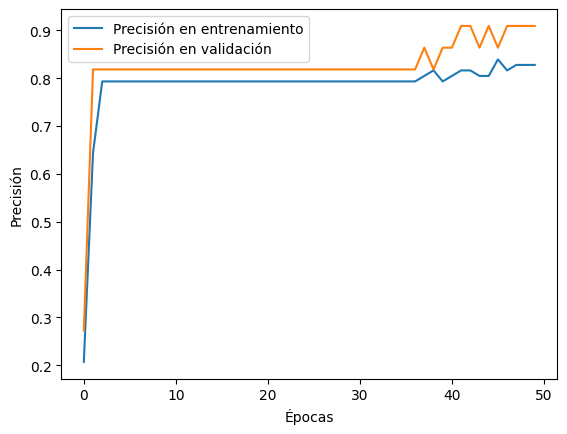

In [173]:
plt.plot(history.history['accuracy'], label='Precisión en entrenamiento')
plt.plot(history.history['val_accuracy'], label='Precisión en validación')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()
plt.show()